# Data Processing

by: Lu Li, UWA

Here, we finially get our topography free gravity disturbance. We can do some data processing to help us understand the geology, also make it as a input for the inversion.

We will use harmonica https://www.fatiando.org/harmonica/latest/index.html with its Equivalent Sources function https://www.fatiando.org/harmonica/latest/user_guide/equivalent_sources/index.html and Grid transformations function https://www.fatiando.org/harmonica/latest/user_guide/transformations.html

In [1]:
# Load necessary package 
import harmonica as hm
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xrft


# Read in Topography Free disturbance

In [2]:
#Read in Gravity data after drift correction
Data = pd.read_csv('example data/Topo_Free_Grav_CAGE.csv', delimiter=r',')

In [3]:
# Let's looks few line of the data
Data.head(5)

,Lon,Lat,Easting,Northing,Height Sea Level,Total Gravity,Free Air Disturbance,Topo Free Disturbance
0,21.077,-31.156,2.012943e+06,-3.115074e+06,1096.9,979100.000000,22.308253,-84.797547
1,20.011,-31.593,1.911136e+06,-3.163718e+06,1119.4,979166.631395,60.785578,-63.739175
2,20.019,-31.689,1.911900e+06,-3.174435e+06,1174.7,979168.331228,71.798325,-54.468625
3,20.019,-31.841,1.911900e+06,-3.191427e+06,1357.8,979143.988157,91.644316,-55.433839
4,20.019,-31.381,1.911900e+06,-3.140091e+06,1069.6,979154.723253,50.574405,-68.243032


# Griding use Equivalent Sources

We will use Equivalent Sources to interpolating our gravity data. The benefit of using Equivalent Sources as it is a physcis based method, which can fill in the area without data using the gravity response of the Equivalent Sources. Read Dampney, C. N. G. (1969). The equivalent source technique. Geophysics, 34(1), 39–53. doi:10.1190/1.1439996 for more details.

In [4]:
# Now we can initialize the harmonica.EquivalentSources class.
equivalent_sources = hm.EquivalentSources(damping=1,depth=1500.0)
equivalent_sources

EquivalentSources(damping=1, depth=1500.0)

In [5]:
# Now we estimate the source coefficients through the harmonica.EquivalentSources.fit method against the observed gravity disturbance.

coordinates = (Data['Easting'], Data['Northing'], Data['Height Sea Level'])
equivalent_sources.fit(coordinates, Data['Topo Free Disturbance'])

EquivalentSources(damping=1, depth=1500.0)

In [6]:
# Now we can get a regular grid using our estimated Equivalent Sources

region = vd.get_region((Data['Easting'], Data['Northing']))

# Build the grid coordinates
grid_coords = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=2e3)


# Grid the gravity disturbances
grid = equivalent_sources.grid(grid_coords, data_names=["gravity_disturbance"])
grid

<xarray.Dataset>
Dimensions:              (northing: 45, easting: 39)
Coordinates:
  * easting              (easting) float64 1.911e+06 1.916e+06 ... 2.101e+06
  * northing             (northing) float64 -3.209e+06 -3.204e+06 ... -2.989e+06
    upward               (northing, easting) float64 2e+03 2e+03 ... 2e+03 2e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 -48.44 -51.0 ... -57.28
Attributes:
    metadata:  Generated by EquivalentSources(damping=1, depth=1500.0)

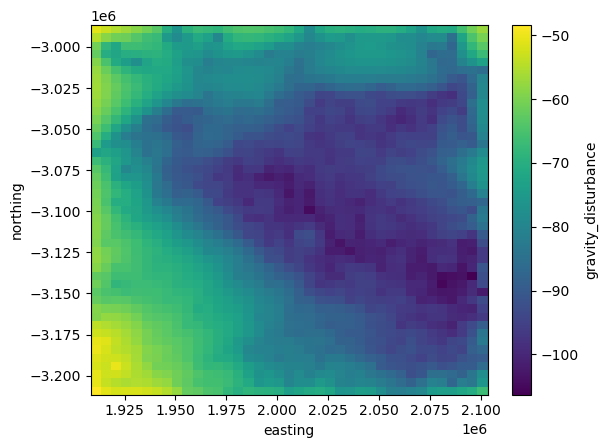

In [7]:
grid.gravity_disturbance.plot()

# Filtering

Due to gravity combine both deep source and shallow source, we need to do some filtering to remove the signal we do not want (depends on our purpose). We will use Grid transformations that apply Fast Fourier Transform based method.

In [8]:
# Since all the grid transformations we are going to apply are based on FFT methods, we usually want to pad them in order their increase the accuracy.

pad_width = {
    "easting": grid.easting.size,
    "northing": grid.northing.size,
}

And then we can pad it, but dropping the height coordinate first (this is needed by the xrft.pad function):

In [9]:
grid_no_height = grid.drop_vars("upward")
grid_padded = xrft.pad(grid_no_height, pad_width,constant_values=grid.gravity_disturbance.mean().values)
grid_padded

<xarray.Dataset>
Dimensions:              (northing: 135, easting: 117)
Coordinates:
  * easting              (easting) float64 1.716e+06 1.721e+06 ... 2.295e+06
  * northing             (northing) float64 -3.434e+06 -3.429e+06 ... -2.764e+06
Data variables:
    gravity_disturbance  (northing, easting) float64 -83.11 -83.11 ... -83.11
Attributes:
    metadata:  Generated by EquivalentSources(damping=1, depth=1500.0)

In [10]:
# Let's do a Gaussian filters 

cutoff_wavelength = 100e3

In [11]:
# Then apply the two filters to our padded grid:
grid_low_freqs = hm.gaussian_lowpass(
    grid_padded.gravity_disturbance, wavelength=cutoff_wavelength
)
grid_high_freqs = hm.gaussian_highpass(
    grid_padded.gravity_disturbance, wavelength=cutoff_wavelength
)

In [12]:
grid_low_freqs = xrft.unpad(grid_low_freqs, pad_width)
grid_high_freqs = xrft.unpad(grid_high_freqs, pad_width)

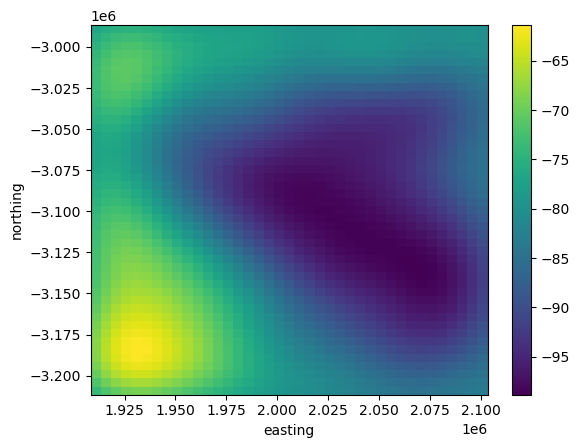

In [13]:
# The low freqs stuff shows deeper source
grid_low_freqs.plot()

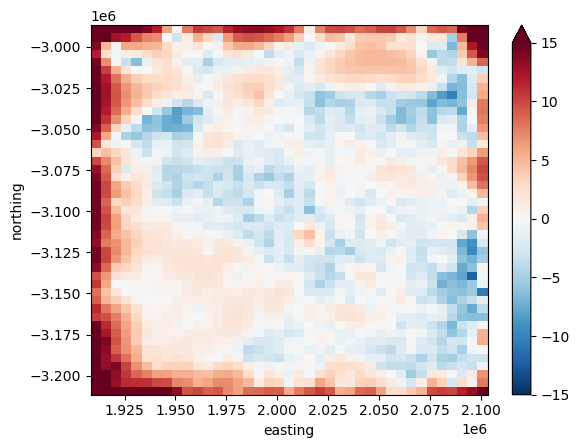

In [14]:
# The low freqs stuff shows shallow source
grid_high_freqs.plot(vmax=15)

In [15]:
# Save the Data to a CSV file

grid_high_freqs.coords['upward'] = (('northing', 'easting'), grid_high_freqs.values - grid_high_freqs.values + 2e3)


grid_high_freqs.name = 'residual_gravity'
data_array = grid_high_freqs.to_dataframe()
data_array.to_csv('example data/residual_gravity.csv')

In the next notebook, we will show how to use simpeg to run inversion using the processed gravity data